# Setup

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import ast
import seaborn as sns

In [ ]:
results_df = pd.read_csv('../../data/topic_model_results.csv',  lineterminator='\n', encoding='utf8')

In [ ]:
results_df.head()

In [ ]:
# Remove \r from column names
results_df.columns = results_df.columns.str.strip()

# Strip \r and other whitespace characters from a specific column (e.g., 'column_name')
results_df['Topic'] = results_df['Topic'].str.strip()

results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful Score,hateful HR,toxic Score,toxic HR
0,i think most singaporeans dont give a damn who...,2020-04-11 15:49:23,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.582897,0,-0.419338,0
1,fair point the secrecy aspect of it slipped my...,2020-04-03 09:59:08,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.116736,0,-1.869363,0
2,range,2020-02-15 15:07:03,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.027191,0,-0.798016,0
3,gt this is binary thinking because you think t...,2020-06-04 07:07:39,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.419287,0,1.119165,1
4,boo boo poor u lmao,2020-10-31 13:52:12,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.952112,0,1.197503,1


In [ ]:
# rename new columns
results_df.rename(columns={
    'hateful Score': 'hateful_score',
    'hateful HR': 'hateful_prediction',
    'toxic Score': 'toxic_score',
    'toxic HR': 'toxic_prediction',
    'Topic Number': 'topic_number',
    'Topic': 'topic'
}, inplace=True)

results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful_score,hateful_prediction,toxic_score,toxic_prediction
0,i think most singaporeans dont give a damn who...,2020-04-11 15:49:23,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.582897,0,-0.419338,0
1,fair point the secrecy aspect of it slipped my...,2020-04-03 09:59:08,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.116736,0,-1.869363,0
2,range,2020-02-15 15:07:03,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.027191,0,-0.798016,0
3,gt this is binary thinking because you think t...,2020-06-04 07:07:39,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.419287,0,1.119165,1
4,boo boo poor u lmao,2020-10-31 13:52:12,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.952112,0,1.197503,1


In [ ]:
results_df['moderation'] = results_df['moderation'].apply(ast.literal_eval)

In [ ]:
# Create boolean flags for collapsed, deleted, low-score, removed, and controversial comments
results_df['is_collapsed'] = results_df['moderation'].apply(lambda x: x.get('collapsed') == True)
results_df['is_deleted'] = results_df['moderation'].apply(lambda x: x.get('collapsed_reason_code') == 'DELETED')
results_df['is_controversial'] = results_df['moderation'].apply(lambda x: x.get('controversiality') == 1)

In [ ]:
results_df['is_controversial'].head()

0    False
1    False
2    False
3    False
4    False
Name: is_controversial, dtype: bool

In [ ]:
# convert data to appropriate datatypes
results_df['text'] = results_df['text'].astype(str)
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'], format='%d/%m/%Y %H:%M')
results_df['username'] = results_df['username'].astype(str)
results_df['link'] = results_df['link'].astype(str)
results_df['link_id'] = results_df['link_id'].astype(str)
results_df['parent_id'] = results_df['parent_id'].astype(str)
results_df['id'] = results_df['id'].astype(str)
results_df['subreddit_id'] = results_df['subreddit_id'].astype(str)
results_df['moderation'] = results_df['moderation'].tolist()
results_df['hateful_score'] = results_df['hateful_score'].astype('float32')
results_df['hateful_prediction'] = results_df['hateful_prediction'].astype('int16')
results_df['toxic_score'] = results_df['toxic_score'].astype('float32')
results_df['toxic_prediction'] = results_df['toxic_prediction'].astype('int16')
results_df['topic_number'] = results_df['topic_number'].astype('category')
results_df['topic'] = results_df['topic'].astype('category')

In [28]:
# Group by year and month to track moderation actions over time
results_df['year_month'] = results_df['timestamp'].dt.to_period('M')

# extract date from datetime stamp
results_df['timestamp'] = results_df['timestamp'].dt.date

results_df['timestamp'].head()

0    2020-04-11
1    2020-04-03
2    2020-02-15
3    2020-06-04
4    2020-10-31
Name: timestamp, dtype: object

# 1. Number of Comments across Time

In [11]:
# count number of comments per day
num_of_comments_per_day_df = results_df.groupby('timestamp')['id'].count()

In [12]:
num_of_comments_per_day_df.head()

timestamp
2020-01-01    128
2020-01-02    171
2020-01-03    195
2020-01-04    156
2020-01-05    180
Name: id, dtype: int64

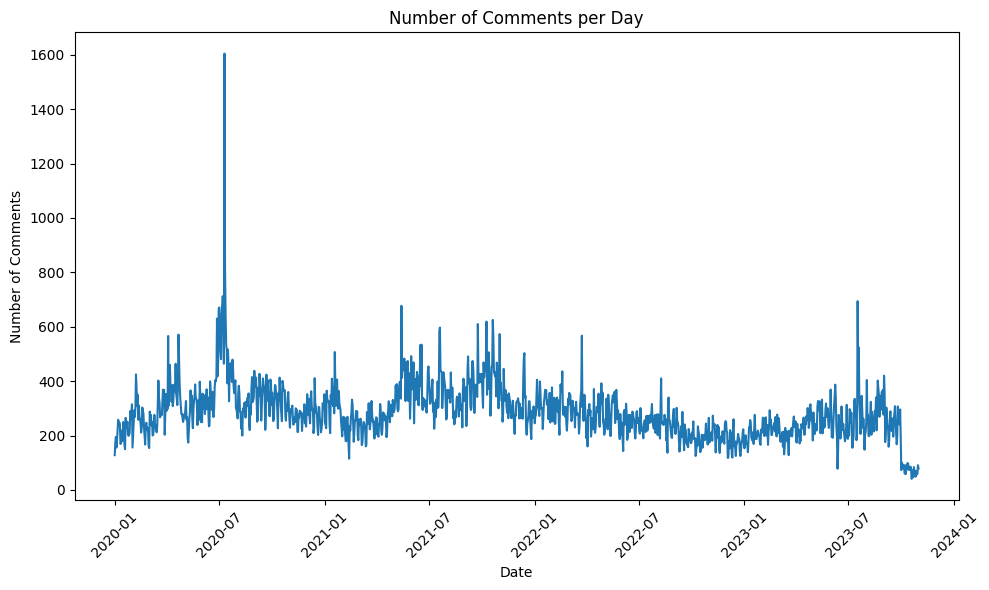

In [13]:
# plot number of comments against time
plt.figure(figsize=(10,6))
plt.plot(num_of_comments_per_day_df.index, num_of_comments_per_day_df.values)
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.title('Number of Comments per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the Time-series plot, most days receive 200-450 comments. There seem to be 2 peaks: 1 in July 2020 and the other in July 2023. Let's take a closer look...

# 2. Hatefulness & Toxicity over Time

We tally the hatefulness and toxicity scores by day to see how the scores have changed over time

In [14]:
# sum hatefulness per day
hatefulness_per_day_df = results_df.groupby('timestamp')['hateful_score'].sum()

# sum toxicity per day
toxicity_per_day_df = results_df.groupby('timestamp')['toxic_score'].sum()

In [15]:
hatefulness_per_day_df.head()

timestamp
2020-01-01   -125.037277
2020-01-02   -169.058228
2020-01-03   -185.944489
2020-01-04   -153.065063
2020-01-05   -177.619736
Name: hateful_score, dtype: float32

In [16]:
toxicity_per_day_df.head()

timestamp
2020-01-01    -73.507362
2020-01-02   -101.269119
2020-01-03    -87.398125
2020-01-04    -83.484047
2020-01-05    -96.996117
Name: toxic_score, dtype: float32

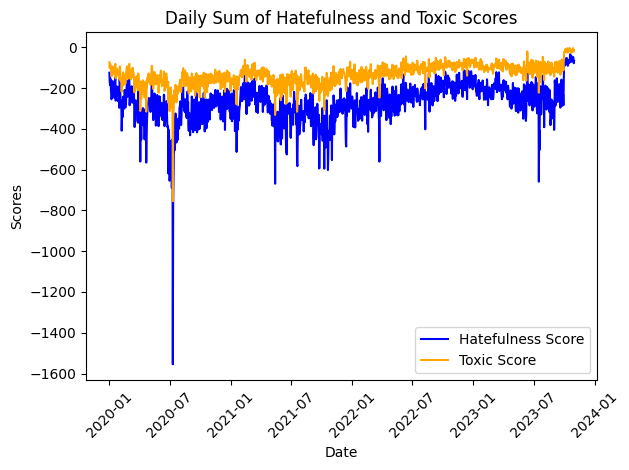

In [17]:
# Plot the first DataFrame
plt.plot(hatefulness_per_day_df.index, hatefulness_per_day_df.values, label='Hatefulness Score', color='blue')

# Plot the second DataFrame
plt.plot(toxicity_per_day_df.index, toxicity_per_day_df.values, label='Toxic Score', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Scores')
plt.title('Daily Sum of Hatefulness and Toxic Scores')
plt.xticks(rotation=45)

# Add a legend to differentiate the lines
plt.legend()

plt.tight_layout()
plt.show()

From the Time-series plot, the daily sum of Hatefulness and Toxic scores are negative, this means that the comments on Reddit are generally not hateful and toxic. However, the graph shows that both hatefulness and toxicity has increased from 2020 to early 2024, both of which increasing by close to 100 units. The 2 lines show that both hatefulness and toxicity are strongly related, as their shapes are roughly the same.

By recalling the plot of the number of comments per day over time, it seems that the more the comments, the less the hatefulness and toxicity that day. So this isn't the most insightful.

# 3. Average Hatefulness and Toxicity per Day

In [18]:
# Group by day and calculate the average score
average_hatefulness_and_toxicity_per_day_df = results_df.groupby(results_df['timestamp']).agg(
    average_hateful_score=('hateful_score', 'mean'), 
    average_toxic_score=('toxic_score', 'mean')
).reset_index()

In [19]:
average_hatefulness_and_toxicity_per_day_df.head()

,timestamp,average_hateful_score,average_toxic_score
0,2020-01-01,-0.976854,-0.574276
1,2020-01-02,-0.988645,-0.592217
2,2020-01-03,-0.953561,-0.448196
3,2020-01-04,-0.981186,-0.535154
4,2020-01-05,-0.986776,-0.538867


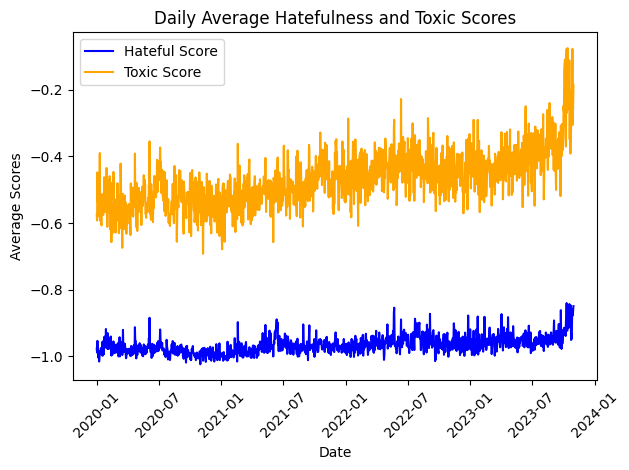

In [20]:
# Plot the first DataFrame
plt.plot(average_hatefulness_and_toxicity_per_day_df['timestamp'], average_hatefulness_and_toxicity_per_day_df['average_hateful_score'], label='Hateful Score', color='blue')

# Plot the second DataFrame
plt.plot(average_hatefulness_and_toxicity_per_day_df['timestamp'], average_hatefulness_and_toxicity_per_day_df['average_toxic_score'], label='Toxic Score', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Scores')
plt.title('Daily Average Hatefulness and Toxic Scores')
plt.xticks(rotation=45)

# Add a legend to differentiate the lines
plt.legend()

plt.tight_layout()
plt.show()

By plotting the daily average hateful and toxic scores, we can see that both scores have increased over time. Both of which saw a sharp increase since March 2023, but especially the months of September and October that year.

It can also be observed that there is more variation in the toxic scores than in the hateful scores.

# 4. Plot toxicity and average number of collapsed comments against time

In [9]:
# Group by day and calculate the average score
average_toxicity_and_moderation_per_day_df = results_df.groupby(results_df['year_month']).agg(
    average_num_collapsed=('is_collapsed', 'mean'), 
    average_toxic_score=('toxic_score', 'mean')
).reset_index()

# create percentage column
average_toxicity_and_moderation_per_day_df['collapsed_percentage'] = average_toxicity_and_moderation_per_day_df['average_num_collapsed']*100

# Convert the 'year_month' column to string or datetime format
average_toxicity_and_moderation_per_day_df['year_month'] = average_toxicity_and_moderation_per_day_df['year_month'].astype(str)

# Convert 'year_month' column to datetime format
average_toxicity_and_moderation_per_day_df['year_month'] = pd.to_datetime(average_toxicity_and_moderation_per_day_df['year_month'])

In [10]:
average_toxicity_and_moderation_per_day_df

,year_month,average_num_collapsed,average_toxic_score,collapsed_percentage
0,2020-01-01,0.024770,-0.527128,2.477010
1,2020-02-01,0.028320,-0.553331,2.831953
2,2020-03-01,0.027930,-0.558396,2.793035
3,2020-04-01,0.033419,-0.536137,3.341902
4,2020-05-01,0.031601,-0.533578,3.160097
5,2020-06-01,0.022312,-0.497530,2.231218
6,2020-07-01,0.017314,-0.485024,1.731391
7,2020-08-01,0.021305,-0.540296,2.130548
8,2020-09-01,0.020033,-0.526546,2.003275
9,2020-10-01,0.022775,-0.528056,2.277474


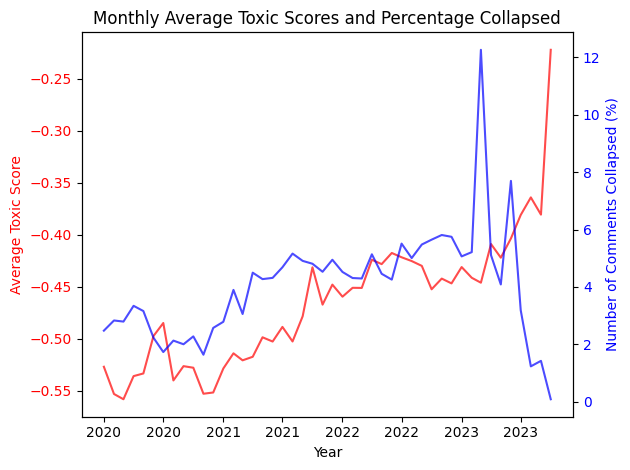

In [23]:

fig, ax1 = plt.subplots()

# Plot the first DataFrame on the left y-axis with transparency
ax1.plot(average_toxicity_and_moderation_per_day_df['year_month'], 
         average_toxicity_and_moderation_per_day_df['average_toxic_score'], 
         label='Toxic Score', color='red', alpha=0.7)
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Toxic Score', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for the second variable with transparency
ax2 = ax1.twinx()
ax2.plot(average_toxicity_and_moderation_per_day_df['year_month'], 
         average_toxicity_and_moderation_per_day_df['collapsed_percentage'], 
         label='Number of Comments Collapsed (%)', color='blue', alpha=0.7)
ax2.set_ylabel('Number of Comments Collapsed (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Format x-axis to show only the year on ax1
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

# Turn off x-axis tick labels for ax2 to prevent duplication
ax2.get_xaxis().set_visible(False)

# Set title and rotate x-axis labels
plt.title('Monthly Average Toxic Scores and Percentage Collapsed')
plt.xticks(rotation=45)

# Use tight_layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()

In general, comments collapsed is positively correlated. But there are 3 exceptions: one in July 2020 (polling day), June 2022 (cabinet changes on june 13), and May 2023 onwards. All 3 periods show an increase in toxicity in comments, but a reduction in collapsed comments.

# 4. Days with Most and Least Hateful and Toxic Comments

In [24]:
# number of comments sorted in descending order
sorted_average_toxicity_then_hatefulness_per_day_df  = average_hatefulness_and_toxicity_per_day_df.sort_values(by=['average_toxic_score', 'average_hateful_score'], ascending=False)

In [25]:
sorted_average_toxicity_then_hatefulness_per_day_df.head()

,timestamp,average_hateful_score,average_toxic_score
1382,2023-10-14,-0.846821,-0.075293
1379,2023-10-11,-0.840128,-0.077212
1396,2023-10-28,-0.858234,-0.077400
1374,2023-10-06,-0.933856,-0.109598
1387,2023-10-19,-0.843076,-0.111988


We can see that the day with comments with the highest average toxicity is 14 October 2023.

In [26]:
sorted_average_toxicity_then_hatefulness_per_day_df.tail()

,timestamp,average_hateful_score,average_toxic_score
43,2020-02-13,-0.997671,-0.657279
518,2021-06-02,-1.000398,-0.657300
75,2020-03-16,-0.996055,-0.674297
368,2021-01-03,-1.002139,-0.678911
312,2020-11-08,-1.012991,-0.692367


While the day with comments with the lowest average toxicity is 8 November 2020.

In [27]:
# filter date for days with most and least toxic comments
most_toxic_df = results_df[results_df['timestamp'] == datetime.date(2023, 10, 14)]
least_toxic_df = results_df[results_df['timestamp'] == datetime.date(2020, 11, 8)]

In [28]:
most_toxic_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful_score,hateful_prediction,toxic_score,toxic_prediction,topic_number,topic,is_collapsed,is_deleted,is_controversial,year_month
240662,see her nails know her character liao,2023-10-14,Sceptikskeptic,/r/singaporehappenings/comments/177p5im/woman_...,t3_177p5im,t3_177p5im,k4ub984,t5_70s6ew,"{'banned_at_utc': None, 'mod_reason_by': None,...",-1.125891,0,-0.316606,0,1,Covid-19,False,False,False,2023-10
243451,typical dick move to push blame,2023-10-14,paranaway,/r/singaporehappenings/comments/177ibz8/singap...,t3_177ibz8,t3_177ibz8,k4ubha7,t5_70s6ew,"{'banned_at_utc': None, 'mod_reason_by': None,...",-0.824888,0,0.927768,1,4,Relationships,False,False,False,2023-10
243726,they should actually stay in the center in mul...,2023-10-14,Josejlloyola,/r/SingaporeRaw/comments/1773qar/was_i_in_the_...,t3_1773qar,t1_k4qtjxo,k4tit62,t5_xnx04,"{'banned_at_utc': None, 'mod_reason_by': None,...",-0.772496,0,0.044711,0,4,Relationships,False,False,False,2023-10
245726,ss hard at work,2023-10-14,GasolineDream,/r/SingaporeRaw/comments/176zuc1/a_man_was_con...,t3_176zuc1,t3_176zuc1,k4ss74a,t5_xnx04,"{'banned_at_utc': None, 'mod_reason_by': None,...",-0.968877,0,-0.767820,0,6,Housing,False,False,False,2023-10
246397,why on earth would we forget about this incide...,2023-10-14,TheMentalMarauder,/r/SingaporeRaw/comments/176zuc1/a_man_was_con...,t3_176zuc1,t1_k4s7248,k4thzv2,t5_xnx04,"{'banned_at_utc': None, 'mod_reason_by': None,...",-0.900796,0,-0.582020,0,9,Unknown,False,False,False,2023-10


In [29]:
least_toxic_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful_score,hateful_prediction,toxic_score,toxic_prediction,topic_number,topic,is_collapsed,is_deleted,is_controversial,year_month
1633,is starhub down now,2020-11-08,Charming_Pie_3208,/r/singapore/comments/jpzdte/rsingapore_random...,t3_jpzdte,t3_jpzdte,gbn17nr,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.189897,0,-1.107023,0,3,Transport,False,False,False,2020-11
1777,npnp please take care of your wallet 1111 coming,2020-11-08,chesterqw,/r/singapore/comments/jq44le/what_are_some_goo...,t3_jq44le,t1_gbk467z,gbk4asb,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.055066,0,-0.333655,0,0,Political,False,False,False,2020-11
3085,chui kong lum par song,2020-11-08,allergictofur,/r/singapore/comments/jq5pmh/the_pap_must_adap...,t3_jq5pmh,t3_jq5pmh,gbk5lns,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.004934,0,-0.662449,0,0,Political,False,False,False,2020-11
5345,ya,2020-11-08,MusicBytes,/r/singapore/comments/jpzdte/rsingapore_random...,t3_jpzdte,t1_gbm1afd,gbm1o3v,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-1.021926,0,-0.804273,0,9,Unknown,False,False,False,2020-11
6290,1 i bought an m1 sim card i also have a spare ...,2020-11-08,troublechromosome,/r/singapore/comments/jq8n01/singaporeans_who_...,t3_jq8n01,t3_jq8n01,gbl7unr,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",-0.898911,0,-0.375003,0,7,Education,False,False,False,2020-11


In [30]:
# Preprocessing function
tokenizer = RegexpTokenizer(r'\b[a-zA-Z]+\b')
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())  # Convert to lowercase and tokenize
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
    return ' '.join(tokens)

In [31]:
# Create a list of DataFrames and their titles for the plots
dataframes = [(most_toxic_df, "Most Toxic"), (least_toxic_df, "Least Toxic")]

# Set up the figure for side-by-side plotting
plt.figure(figsize=(30, 15))

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

C:\Users\caleb\AppData\Local\Temp\ipykernel_82032\2964807214.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].fillna('')
c:\Users\caleb\OneDrive - National University of Singapore\school\DSA\DSA4264\DSA4264\venv\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


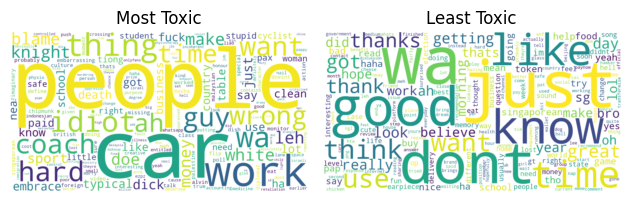

In [32]:
# Loop through the DataFrames to generate word clouds
for i, (df, title) in enumerate(dataframes):
    # Create TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words='english', min_df=1, max_features=500)

    # Fit and transform the data
    df['text'] = df['text'].fillna('')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'].values)

    # Sum the TF-IDF scores for each term across all documents
    tfidf_sum = tfidf_matrix.sum(axis=0)

    # Create a DataFrame to hold the words and their corresponding scores
    words = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_sum.A1  # Convert to a 1D array

    # Create a dictionary mapping words to their TF-IDF scores
    word_scores = dict(zip(words, tfidf_scores))

    # Generate the word cloud
    wordcloud = WordCloud(width=1500, height=800, background_color='white', colormap='viridis').generate_from_frequencies(word_scores)

    # Display the word cloud
    plt.subplot(1, 2, i + 1)  # Create a subplot for each word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title(title)

# Show the plots
plt.tight_layout()
plt.show()

By comparing the 2 wordclouds, we can see the difference in choice of words, with the most toxic wordcloud using negative and adverserial words like, 'idiot', 'wrong', 'blame' and 'hard', while the least toxic wordcloud has more positive words like, 'good', 'thanks', 'like' and 'great'.

As for one-word topics that people are talking about, the most toxic wordcloud contains words like, 'people', 'car', 'work', 'money' and 'cyclist'. This shows that people might be complaining about transportation, work and finances. Whereas there are no big topics that reddit users talk about when they are posting relatively more positive comments, according to the least toxic wordcloud.

# 5. Days with Most Number of Comments

In [33]:
# number of comments sorted in descending order
sorted_num_of_comments_per_day_df = num_of_comments_per_day_df.sort_values(ascending=False)

In [34]:
sorted_num_of_comments_per_day_df.head()

timestamp
2020-07-10    1604
2020-07-11     813
2020-07-07     712
2023-07-17     694
2020-07-06     680
Name: id, dtype: int64

From this table, we can pinpoint the 2 events surrounding the 2 peaks in the number of comments: 10 July 2020 is polling day, and 17 July 2023 was the news breaking out that Speaker Tan Chuan-Jin and Tampines GRC MP Cheng Li Hui resigned over an affair.

We can double-check if the reddit comments were indeed about those events.

# 6. Check Polling Day

In [35]:
# filter date for 10 july 2020
polling_day_df = results_df[results_df['timestamp'] == datetime.date(2020, 7, 10)]

In [36]:
# expand resolution to see full text
pd.set_option('display.max_colwidth', None)

polling_day_df['text'].head(20)

83                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              they could technically retire an mp in a smc to trigger a by election
163                                                                                                                                                                                                                                                                                                                                                                                                                                    my sense as

The text data confirms that most of Reddit comments on Polling Day (10 July 2020) were about Polling Day and singaporean politics, including how it is affecting lives of Singaporeans.

# 7. Check 17 July 2023

In [37]:
seventeen_july_twentytwentythree_df = results_df[results_df['timestamp'] == datetime.date(2023, 7, 17)]

In [38]:
seventeen_july_twentytwentythree_df['text'].head(20)

236840                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               idk if people call me low ses i love encik tan
236844                                                                                              

Again, the text data confirms that most of Reddit comments on 17 July 2023 were about Speaker Tan Chuan-Jin and Tampines GRC MP Cheng Li Hui's affair in light of the news of their resignations.

# 8. COVID extend restictions

In [39]:
twenty_october_twentytwentyone_df = results_df[results_df['timestamp'] == datetime.date(2021, 10, 20)]

In [40]:
num_of_comments_per_day_df.head()

timestamp
2020-01-01    128
2020-01-02    171
2020-01-03    195
2020-01-04    156
2020-01-05    180
Name: id, dtype: int64

# Find Average Day

In [41]:
# Step 1: Calculate the median of the 'id' column (comments count per day)
median_comments = num_of_comments_per_day_df.median()

# Step 2: Find the timestamp where the comments count is closest to the median
closest_timestamp = (num_of_comments_per_day_df - median_comments).abs().idxmin()

In [42]:
print(closest_timestamp)

2021-12-07


Average Day is 2021-12-07

# 8. Toxicity and Hatefulness of Comments on Days with Events vs Average Day

In [43]:
# List of dates to filter for
dates_to_filter = [
    datetime.date(2021, 12, 7),
    datetime.date(2020, 7, 10),
    datetime.date(2023, 7, 17),
    datetime.date(2021, 10, 20)
]

# Filter DataFrame for these specific dates
big_events_vs_average_day_df = results_df[results_df['timestamp'].isin(dates_to_filter)]

In [44]:
big_events_vs_average_day_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation,hateful_score,hateful_prediction,toxic_score,toxic_prediction,topic_number,topic,is_collapsed,is_deleted,is_controversial,year_month
83,they could technically retire an mp in a smc to trigger a by election,2020-07-10,deangsana,/r/singapore/comments/homxdq/singapore_general_elections_2020_polling_results/fxjq2mi/,t3_homxdq,t1_fxjpw7i,fxjq2mi,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, 'collapsed_reason': None, 'controversiality': 0}",-1.137040,0,-0.859267,0,4,Relationships,False,False,False,2020-07
163,my sense as foreigner is that this time around people are mostly pissed at the rigged system not do much the foreigners like two elections ago,2020-07-10,generaladdict,/r/singapore/comments/homxdq/singapore_general_elections_2020_polling_results/fxjgu97/,t3_homxdq,t1_fxjgobr,fxjgu97,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, 'collapsed_reason': None, 'controversiality': 0}",-0.927926,0,-0.360097,0,0,Political,False,False,False,2020-07
359,tpl really is hard af carrier kate spate now so strong even lhl go thr also cannot win future 5g minister,2020-07-10,xxxr18,/r/singapore/comments/homxdq/singapore_general_elections_2020_polling_results/fxjkhb6/,t3_homxdq,t3_homxdq,fxjkhb6,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, 'collapsed_reason': None, 'controversiality': 0}",-0.886660,0,0.122014,1,2,Race & Religion,False,False,False,2020-07
497,do you pay for your hotel stay or is it still paid by gahmen,2020-07-10,kenrick95,/r/singapore/comments/hocfby/rsingapore_random_discussion_and_small_questions/fxi9lrg/,t3_hocfby,t1_fxi86ux,fxi9lrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, 'collapsed_reason': None, 'controversiality': 0}",-1.189247,0,-1.300231,0,2,Race & Religion,False,False,False,2020-07
509,i mean even my dad became an opposition supporter and hes usually the target demographic for them,2020-07-10,bricklegos,/r/singapore/comments/houigp/are_we_becoming_divided_politically_agewise/fxk4msa/,t3_houigp,t1_fxk3yas,fxk4msa,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, 'collapsed_reason': None, 'controversiality': 0}",-1.052267,0,-0.432570,0,0,Political,False,False,False,2020-07


C:\Users\caleb\AppData\Local\Temp\ipykernel_82032\2599032979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_events_vs_average_day_df['timestamp'] = pd.to_datetime(big_events_vs_average_day_df['timestamp'], errors='coerce')
C:\Users\caleb\AppData\Local\Temp\ipykernel_82032\2599032979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_events_vs_average_day_df['timestamp'] = big_events_vs_average_day_df['timestamp'].dt.strftime('%Y-%m-%d')
C:\Users\caleb\AppData\Local\Temp\ipykernel_82032\2599032

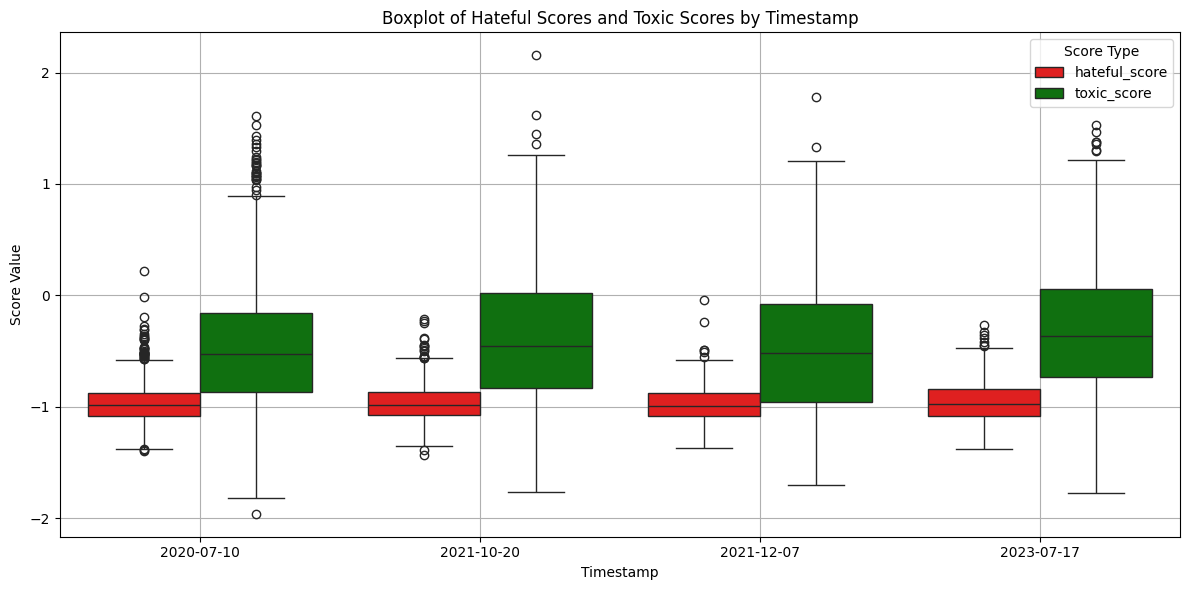

In [45]:
# Convert to datetime if it's not already
big_events_vs_average_day_df['timestamp'] = pd.to_datetime(big_events_vs_average_day_df['timestamp'], errors='coerce')

# Now, convert it to string format
big_events_vs_average_day_df['timestamp'] = big_events_vs_average_day_df['timestamp'].dt.strftime('%Y-%m-%d')

# Define a mapping for renaming timestamps
timestamp_mapping = {
    '2024-01-01': 'Event A',
    '2024-01-02': 'Event B',
    '2024-01-03': 'Event C',
    '2024-01-04': 'Event D'
}

# Rename the timestamps in the DataFrame using the mapping
big_events_vs_average_day_df['timestamp'] = big_events_vs_average_day_df['timestamp'].replace(timestamp_mapping)

# Ensure that the timestamp column is treated as a categorical variable
big_events_vs_average_day_df['timestamp'] = big_events_vs_average_day_df['timestamp'].astype('category')

# Melt the DataFrame to have a long format suitable for seaborn
melted_df = big_events_vs_average_day_df.melt(
    id_vars=['timestamp'],
    value_vars=['hateful_score', 'toxic_score'],
    var_name='score_type',
    value_name='score_value'
)

# Create a color palette
palette = {
    'hateful_score': 'red',
    'toxic_score': 'green'
}

# Create a boxplot with custom colors
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_df, x='timestamp', y='score_value', hue='score_type', palette=palette)

# Customize the plot
plt.title('Boxplot of Hateful Scores and Toxic Scores by Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Score Value')
plt.legend(title='Score Type')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

boxplot shows average day and days with big events have similar toxicity and hatefulness scores

# 9. Moderation between big events vs average day

Legend:

2020-07-10: polling day

2021-10-20: "average day"

2021-12-07: extend of covid restrictions

2023-07-17: affair

In [48]:
# Ensure that the columns are converted to integers
big_events_vs_average_day_df['is_collapsed'] = big_events_vs_average_day_df['is_collapsed'].astype(int)
big_events_vs_average_day_df['is_deleted'] = big_events_vs_average_day_df['is_deleted'].astype(int)
big_events_vs_average_day_df['is_controversial'] = big_events_vs_average_day_df['is_controversial'].astype(int)

# Group by 'timestamp' and calculate the sum for each numeric column
summary_df = big_events_vs_average_day_df.groupby('timestamp')[['is_collapsed', 'is_deleted', 'is_controversial']].sum().reset_index()

C:\Users\caleb\AppData\Local\Temp\ipykernel_82032\1876040779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_events_vs_average_day_df['is_collapsed'] = big_events_vs_average_day_df['is_collapsed'].astype(int)
C:\Users\caleb\AppData\Local\Temp\ipykernel_82032\1876040779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_events_vs_average_day_df['is_deleted'] = big_events_vs_average_day_df['is_deleted'].astype(int)
C:\Users\caleb\AppData\Local\Temp\ipykernel_82032\1876040779.py:4: SettingWithCopy

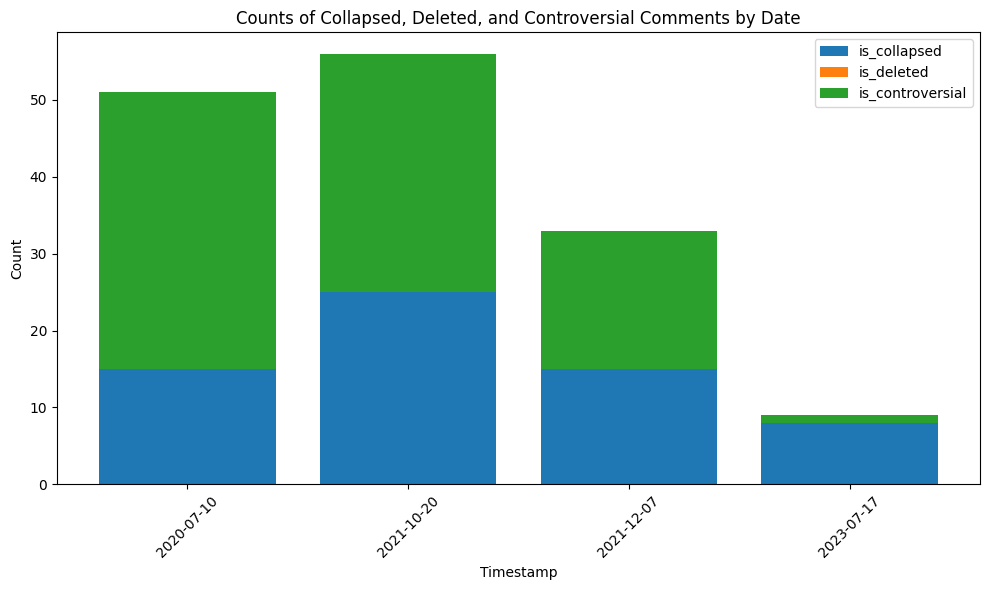

In [50]:
# Plot the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each category as a stacked bar
ax.bar(summary_df['timestamp'], summary_df['is_collapsed'], label='is_collapsed')
ax.bar(summary_df['timestamp'], summary_df['is_deleted'], bottom=summary_df['is_collapsed'], label='is_deleted')
ax.bar(summary_df['timestamp'], summary_df['is_controversial'], 
       bottom=summary_df['is_collapsed'] + summary_df['is_deleted'], label='is_controversial')

# Labels and title
ax.set_xlabel('Timestamp')
ax.set_ylabel('Count')
ax.set_title('Counts of Collapsed, Deleted, and Controversial Comments by Date')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

While there is not much difference in the toxicity and hatefulness across these 4 days, there are significant differences between the moderation in these days.

On a single-day basis, the stacked bar plot shows that an average day is observed to have more moderation than on days with the most number of comments.

Additionally, the average day has more collapsed comments than days where there are big events.

On the day that news broke out of the affair, there were significantly less comments labelled controversial than the other 2 events and on an average day.

It is possible that more moderation might be needed to moderate comments especially during days where news break out, just by the sheer number of comments posted on the day. A decreased number of comment being moderated might make reddit users more exposed to toxic and hateful speech during these days

# 9. Check for Yearly Patterns

In [71]:
pd.reset_option('display.max_colwidth')
results_df.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation\r
0,i think most singaporeans dont give a damn who...,2020-04-11,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '..."
1,fair point the secrecy aspect of it slipped my...,2020-04-03,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '..."
2,range,2020-02-15,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '..."
3,gt this is binary thinking because you think t...,2020-06-04,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '..."
4,boo boo poor u lmao,2020-10-31,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '..."


In [68]:
results_df_2 = results_df.copy()

In [70]:
print(results_df_2['text'].dtype)

object


In [72]:
#ensure timestamp column is datetime object
results_df_2['timestamp'] = pd.to_datetime(results_df_2['timestamp'])

# create 2 new columns in reddit_df
results_df_2['year'] = results_df_2['timestamp'].dt.year
results_df_2['month'] = results_df_2['timestamp'].dt.month

In [73]:
results_df_2.head()

,text,timestamp,username,link,link_id,parent_id,id,subreddit_id,moderation\r,year,month
0,i think most singaporeans dont give a damn who...,2020-04-11,invigo79,/r/singapore/comments/fz7vtl/im_quite_interest...,t3_fz7vtl,t3_fz7vtl,fn3gbrg,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",2020,4
1,fair point the secrecy aspect of it slipped my...,2020-04-03,potatetoe_tractor,/r/singapore/comments/fu3axm/government_to_tab...,t3_fu3axm,t1_fmasya5,fmau5k3,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",2020,4
2,range,2020-02-15,CrossfittJesus,/r/singapore/comments/f4ac70/what_is_ps_defens...,t3_f4ac70,t3_f4ac70,fhp05xc,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",2020,2
3,gt this is binary thinking because you think t...,2020-06-04,nomad80,/r/singapore/comments/gw55cx/notoracism/fsu4fyd/,t3_gw55cx,t1_fsu3dsf,fsu4fyd,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",2020,6
4,boo boo poor u lmao,2020-10-31,pirorok,/r/singapore/comments/jl6abo/rsingapore_random...,t3_jl6abo,t1_gap4e9y,gap4vkl,t5_2qh8c,"{'removal_reason': None, 'collapsed': False, '...",2020,10


In [74]:
# count number of comments by year and month 
num_of_comments_per_month_by_year_df = results_df_2.groupby(['year', 'month'])['id'].count().reset_index()

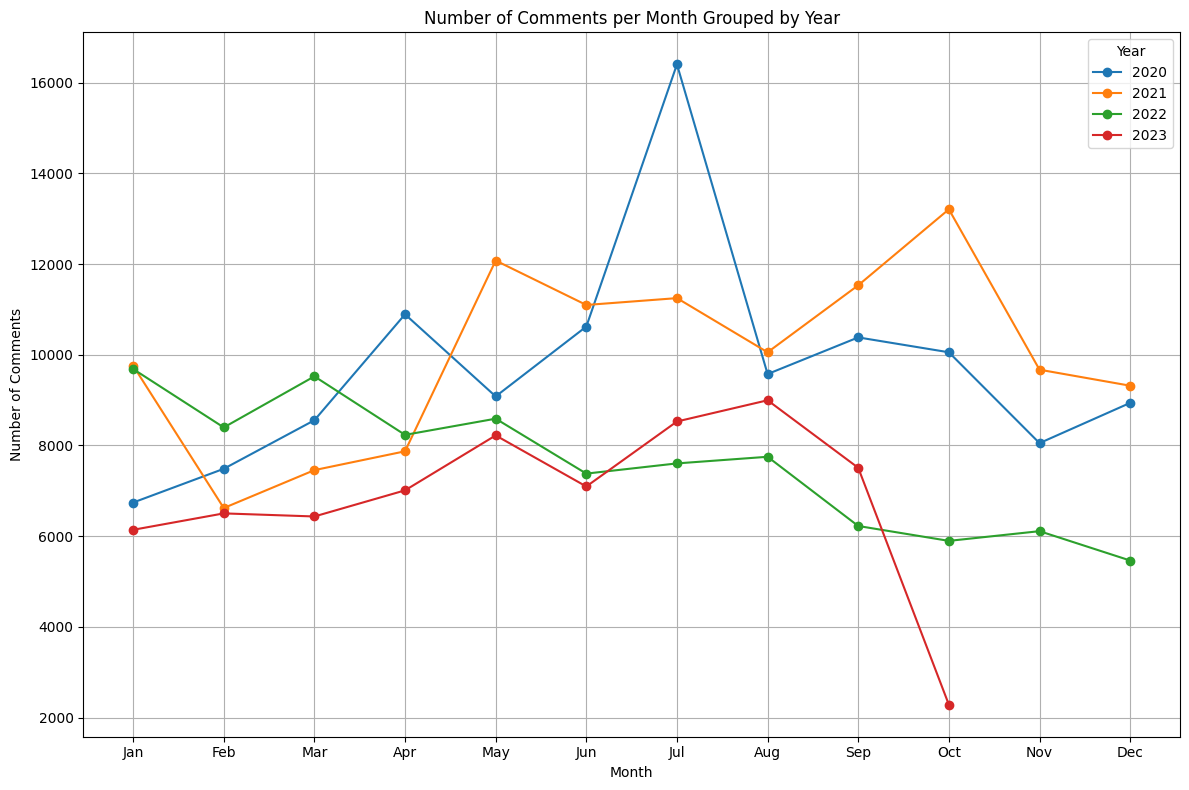

In [75]:
# Plotting
plt.figure(figsize=(12, 8))

# Loop through each year and plot number of comments per month
for year in num_of_comments_per_month_by_year_df['year'].unique():
    data_by_year = num_of_comments_per_month_by_year_df[num_of_comments_per_month_by_year_df['year'] == year]
    plt.plot(data_by_year['month'], data_by_year['id'], marker='o', label=str(year))

# Customizing the plot
plt.xlabel('Month')
plt.ylabel('Number of Comments')
plt.title('Number of Comments per Month Grouped by Year')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

The Time-series plot grouped by year and month above shows that there is not much of a seasonal pattern for when people post Reddit comments, but are more driven by events in Singapore, especially political events.

We can see a more obvious peak in October 2021. Let's take a closer look...

In [76]:
# filter comments posted in October 2021
october_twentytwentyone_df = results_df_2[(results_df_2['timestamp'] >= '2021-10-01') & (results_df_2['timestamp'] <= '2021-10-31')]

In [93]:
# count number of comments per day in the month of October 2021
num_of_comments_per_day_in_october_twentytwentyone_df = october_twentytwentyone_df.groupby('timestamp')['id'].count()

# sort days based on number of comments
num_of_comments_per_day_in_october_twentytwentyone_df.sort_values(ascending=False).head()

timestamp
2021-10-20    625
2021-10-09    619
2021-10-21    562
2021-10-13    506
2021-10-04    469
Name: id, dtype: int64

We see that 20 October has the most comments in October 2021. We researched online and found that this coincided with a Press Release by the COVID-19 task force of the extension of COVID-19 restrictions under the "stabilisation phase". Read here for more information: https://www.channelnewsasia.com/singapore/stabilisation-phase-restrictions-extended-nov-21-dining-social-gatherings-2256766.

In [96]:
results_df_2['timestamp'] = results_df_2['timestamp'].dt.date

# filter comments posted on 20 October 2021
twenty_october_twentytwentyone_df = results_df_2[results_df_2['timestamp'] == datetime.date(2021, 10, 20)]

We take a closer look at the comments themselves to confirm our suspicions...

In [98]:
twenty_october_twentytwentyone_df['text'].head(20)

2927                                                                                                                                                                            spitting facts but its wasted on fools here \n\nsincerely though do what you can quit when you have to you dont owe this country and its people any more sg society can go to hell in a handbasket for all any of us care the difference is you and your family members who are hcws will definitely be welcome to emigrate anywhere in the world and get paidtreated better than sg
3833                                                                                                                                                                                                                                                                                                                                                                                                                                                               

By analysing the comments of this day. we can see some comments about the COVID-19 restrictions, though not as prevalent as compared to the first 2 events.

Other miscellaneous comments that can be found here are about relationship issues and public transport.

# Conclusion

These Time-series plots show that there Reddit comments are more driven by events in Singapore, especially political events and events that affect Singaporeans' way of life.